In [1]:
import jax.numpy as jnp
from jax import jit, vmap
from jax.random import PRNGKey, split, normal
import matplotlib.pyplot as plt
import jax
import pickle

In [2]:
def calculate_theory_approx(n, D, beta):
    prefactor = 1 / (2*(1 - n/D))
    
    pi_term = jnp.pi ** (beta + 1)
    csc_term = 1 / jnp.sin(jnp.pi / (1 + beta))
    denominator = 1 + n + beta + (n * beta)
    inner_fraction = csc_term / denominator
    parenthetical = inner_fraction ** (1 + beta)
    
    result = prefactor * n * pi_term * parenthetical
    
    return result

In [3]:
from theory_sweep_gpu import betas, M, Ds
Ns = range(200, 601, 100)

losses = {}
losses_theory = {}
for beta in betas:
    losses[beta] = {}
    losses_theory[beta] = {}
    for N in Ns:
        losses_theory[beta][N] = {}
        losses_theory[beta][N] = [calculate_theory_approx(N, D, beta) for D in Ds]

        losses[beta][N] = {}
        with open(f'simulation_data/losses_averaged_N_{N}_beta_{beta}.pkl', 'rb') as f:
            l = pickle.load(f)
        losses[beta][N] = l[N][beta]

[CpuDevice(id=0)]


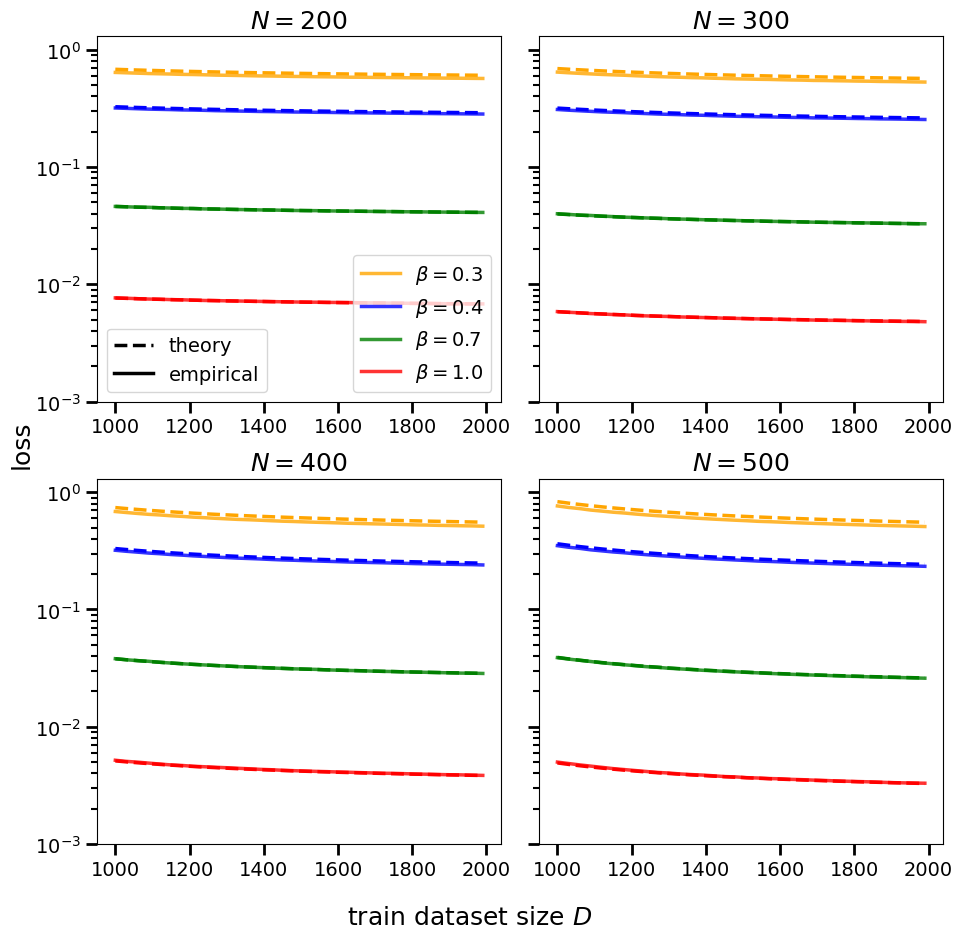

In [4]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig1, axs1 = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

colors = {0.3: 'orange', 0.4: 'blue', 0.7: 'green', 1.0: 'red'}

theory_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2.5, label='theory')
empirical_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label='empirical')

Ns_grid = [200, 300, 400, 500]

for i, N in enumerate(Ns_grid):
    ax = axs1[i // 2, i % 2]
    ax.set_title(r'$N = {}$'.format(N), fontsize=18)
    
    ax.set_yscale('log') 
    ax.set_ylim(1e-3, 1.3e0)

    beta_lines = []
    for beta in betas:
        color = colors[beta]
        line, = ax.plot(Ds, losses[beta][N], label=r'$\beta={}$'.format(beta), color=color, linestyle='-', linewidth=2.5, alpha=0.8)
        beta_lines.append(line)
        
        ax.plot(Ds, losses_theory[beta][N], color=color, linestyle='--', linewidth=2.5)

    if i == 0:
        l1 = ax.legend(handles=beta_lines, fontsize=14, loc='lower right', frameon=True, ncol=1)
        ax.legend(handles=[theory_line, empirical_line], loc='lower left', fontsize=14, frameon=True)
        ax.add_artist(l1)

    ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1.5)

fig1.text(0.5, 0.02, r'train dataset size $D$', ha='center', fontsize=18)  # Adjusted vertical position for spacing
fig1.text(0.04, 0.5, r'loss', va='center', rotation='vertical', fontsize=18)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# uncomment this if you want to save the figure:
# fig1.savefig('losses_vs_D_fixed_N_varying_beta.pdf', dpi=300)

plt.show()


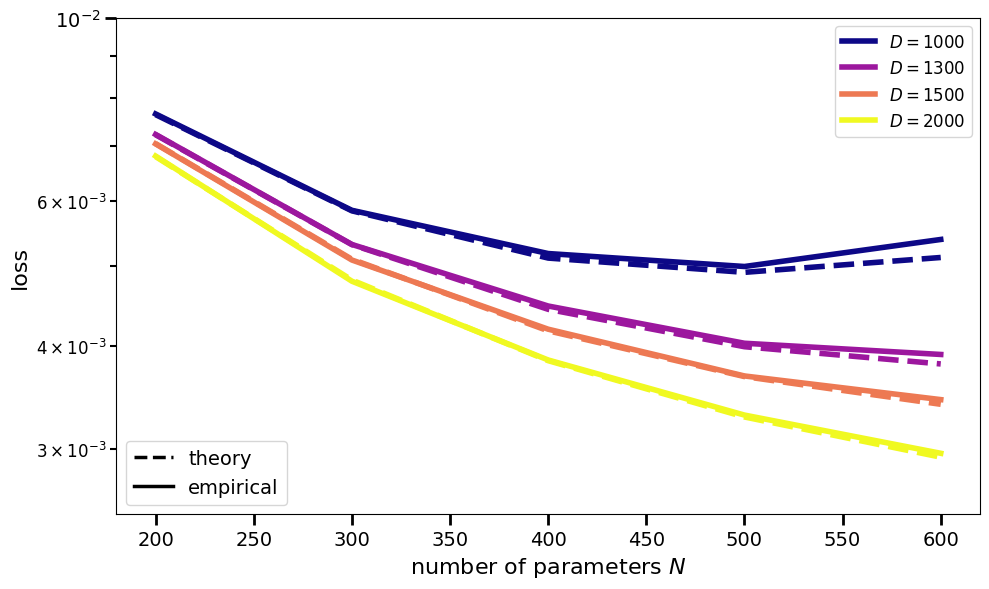

In [5]:
import matplotlib.cm as cm
import numpy as np


Ds_list = list(Ds)
beta=1.0

# Choose 5 different values of D to analyze
selected_Ds = [1000, 1300, 1510, 1990]

theory_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2.5, label='theory')
empirical_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label='empirical')

fig, ax = plt.subplots(figsize=(10, 6))

colors = cm.plasma(np.linspace(0, 1, len(selected_Ds)))

for i, D in enumerate(selected_Ds):
    rounded_D = int(round(D, -2))  # Round D to the nearest "nice" number (hundreds place)
    for beta in betas[-1:]:
        empirical_losses = [losses[beta][N][Ds_list.index(D)] for N in Ns]
        theoretical_losses = [losses_theory[beta][N][Ds_list.index(D)] for N in Ns]
        
        color = colors[i]
        
        ax.plot(Ns, empirical_losses, label=f'$D={rounded_D}$', color=color, linestyle='-', linewidth=4)
        
        ax.plot(Ns, theoretical_losses, color=color, linestyle='--', linewidth=4)

ax.set_xlabel(r'number of parameters $N$', fontsize=16)
ax.set_ylabel(r'loss', fontsize=16)
ax.set_yscale('log')  # Use log scale for better visibility
ax.set_ylim(2.5e-3, 1e-2)
ax.tick_params(axis='both', which='major', labelsize=14, length=8, width=2)
ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1.5)

l1 = ax.legend(fontsize=12, frameon=True, loc='upper right')
ax.legend(handles=[theory_line, empirical_line], loc='lower left', fontsize=14, frameon=True)
        
ax.add_artist(l1)

plt.tight_layout()
plt.show()

# uncomment to save fig
# fig.savefig('losses_vs_N_fixed_D.pdf', dpi=300)
